You need to run this before doing the tasks:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class GridSSP:
    def __init__(self, size=5, goal=(4, 4), gamma=1.0,seed=0):
        self.size = size
        self.goal = goal
        self.gamma = gamma
        self.actions = ['U', 'D', 'L', 'R']
        self.states = [(i, j) for i in range(size) for j in range(size)]
        self.state_idx = {s: idx for idx, s in enumerate(self.states)}
        self.rng = np.random.default_rng(seed)
        self.custom_probs = self._generate_probs()

# setup of grid and directions of movement. Think each grid is a street intersection in city and goal is to find end destination. 
# Gamma (1.0) says the robot cares equally about immediate and future rewards & the seed ensures reproducibility (same random pizza slip behavior each time). 
    
    def _generate_probs(self):
        # Input:  None
        # Output: dict mapping (state, action) -> {'intended','slip1','slip2','stay'} probabilities
        #np.random.seed(0)
        probs = {}
        for s in self.states:
            for a in self.actions:
                p1 = self.rng.uniform(0.5, 0.8)
                p2 = self.rng.uniform(0.05, 0.10)
                p3 = self.rng.uniform(0.05, 0.10)
                stay = max(0.0, 1.0 - p1 - p2 - p3)
                probs[(s, a)] = {'intended': p1, 'slip1': p2, 'slip2': p3, 'stay': stay}
        return probs

#adding some uncertainty to each moves

    def transition_probs(self, s, a):
        # Input:  s (tuple[int,int]) state, a (str in {'U','D','L','R'}) action
        # Output: list of (next_state (tuple[int,int]), probability (float)) pairs; sums to 1
        # Note:   goal is absorbing for any action
        if s == self.goal:
            return [(self.goal, 1.0)]

        i, j = s
        moves = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
        sideways = {'U': ['L', 'R'], 'D': ['L', 'R'], 'L': ['U', 'D'], 'R': ['U', 'D']}
        probs = []
        pset = self.custom_probs[(s, a)]
        ni, nj = max(0, min(i + moves[a][0], self.size - 1)), max(0, min(j + moves[a][1], self.size - 1))
        probs.append(((ni, nj), pset['intended']))
        for idx, side in enumerate(sideways[a]):
            si, sj = i + moves[side][0], j + moves[side][1]
            si, sj = max(0, min(si, self.size - 1)), max(0, min(sj, self.size - 1))
            probs.append(((si, sj), pset['slip1'] if idx == 0 else pset['slip2']))
        probs.append(((i, j), pset['stay']))
        return probs

    def reward(self, s, a, s_next):
        # Input: s (state), a (action), s_next (next state)
        # Output: scalar reward (float)
        # Default: -1 per step until the absorbing goal (0 there)
        return 0.0 if s_next == self.goal else -1.0

# given a fixed strategy (policy), computes how good each state is (expected total reward)
    def evaluate_policy(self, policy):
        # Input:  policy (dict) mapping state -> action ('U','D','L','R')
        # Output: V (np.ndarray shape (size, size)) value function with gamma=1 and V(goal)=0
        # Method: build full P,R; remove goal row/col; solve (I - P_T) v_T = R_T

        n = self.size * self.size
        P = np.zeros((n, n), dtype=float)
        R = np.zeros(n, dtype=float)

        for s in self.states:
            idx = self.state_idx[s]
            if s == self.goal:
                P[idx, idx] = 1.0  # absorbing
                R[idx] = 0.0
                continue

            a = policy[s]

            # Aggregate duplicates from transition_probs(s,a)
            row = {}
            for s2, p in self.transition_probs(s, a):
                jdx = self.state_idx[s2]
                row[jdx] = row.get(jdx, 0.0) + float(p)

            # Assert that the transition probabilities sum to one
            total = sum(row.values())
            assert abs(total - 1.0) < 1e-12, f"P row sum={total} at state {s}, action {a}"

            # Fill P and immediate reward (-1 per step -> expected is -1)
            for jdx, p in row.items():
                P[idx, jdx] += p
            R[idx] = -1.0

        # Remove goal row/col -> transient subsystem
        g = self.state_idx[self.goal]
        mask = np.ones(n, dtype=bool)
        mask[g] = False
        P_T = P[mask][:, mask]
        R_T = R[mask]

        # Solve (I - P_T) v_T = R_T  (gamma = 1)
        v_T = np.linalg.solve(np.eye(P_T.shape[0]) - P_T, R_T)

        # Stitch back with V(goal)=0
        V = np.zeros(n, dtype=float)
        V[mask] = v_T
        V[g] = 0.0

        return V.reshape((self.size, self.size))
    

# uses dynamic programming to discover the best strategy (optimal policy) by trial and update
    def value_iteration(self, tol=1e-8, max_iters=10000):
        # Input:  tol (float) stopping threshold on the max Bellman residual;
        #         max_iters (int) cap on iterations
        # Output: (V_grid, policy, info) where
        #         V_grid is np.ndarray shape (size,size),
        #         policy is dict[state]->best action ('U','D','L','R') with goal -> '.',
        #         info is dict with {'iterations': int, 'max_residual': float}
        import numpy as np

        gamma = float(self.gamma)

        # Initialize V(s)=0; enforce V(goal)=0 at all times
        V = {s: 0.0 for s in self.states}
        V[self.goal] = 0.0

        def q_value(s, a, Vsnap):
            """One-step lookahead: Q(s,a) = sum_{s'} P(s'|s,a) [ R(s,a,s') + gamma * V(s') ]"""
            val = 0.0
            for s2, p in self.transition_probs(s, a):
                r = self.reward(s, a, s2)
                # with gamma=1, V(goal) is fixed at 0; with gamma<1, this line still works
                val += p * (r + gamma * Vsnap[s2])
            return val

        # Value iteration loop
        it = 0
        for it in range(1, max_iters + 1):
            V_old = V.copy()
            delta = 0.0
            for s in self.states:
                if s == self.goal:
                    V[s] = 0.0
                    continue
                # Bellman optimality backup
                best = -np.inf
                for a in self.actions:
                    qa = q_value(s, a, V_old)
                    if qa > best:
                        best = qa
                V[s] = best
                delta = max(delta, abs(V[s] - V_old[s]))
            # Convergence check
            if delta < tol:
                break

        # Greedy policy extraction w.r.t. the final V
        policy = {}
        for s in self.states:
            if s == self.goal:
                policy[s] = '.'
                continue
            best_a, best_val = None, -np.inf
            for a in self.actions:
                qa = q_value(s, a, V)
                if qa > best_val:
                    best_val, best_a = qa, a
            policy[s] = best_a

        # Pack V into a grid
        V_grid = np.zeros((self.size, self.size), dtype=float)
        for (i, j), val in V.items():
            V_grid[i, j] = val

        info = {'iterations': it, 'max_residual': float(delta)}
        return V_grid, policy, info


    ####
    #### Here comes the part used to create a simulation
    ####

    def _sample_from_dist(self, items, probs, rng):
        # Input:  items (list[Any]), probs (list[float]) summing to 1, rng (np.random.Generator)
        # Output: one sampled item from items according to probs
        c = np.cumsum(probs)
        r = rng.random()
        idx = int(np.searchsorted(c, r, side="right"))
        return items[idx]
# picks one item randomly according to given probabilities

    def _pick_action(self, policy, s, rng):
        # Input:  policy (dict[state]->action OR dict[state]->{action:prob}), s (tuple), rng (np.random.Generator)
        # Output: action (str in {'U','D','L','R'})
        pi_s = policy[s]
        if isinstance(pi_s, str):
            return pi_s
        acts, probs = zip(*pi_s.items())
        assert abs(sum(probs) - 1.0) < 1e-12, f"Policy probs at {s} must sum to 1."
        return self._sample_from_dist(list(acts), list(probs), rng)       
# chooses what action to take from the policy (handles both fixed and probabilistic policies)

    def step(self, s, a, rng=None):
        # Input:  s (state tuple), a (action str), rng (np.random.Generator or None)
        # Output: (s_next (state tuple), r (float), done (bool))
        if s == self.goal:
            return self.goal, 0.0, True
        if rng is None:
            rng = np.random.default_rng()

        outcomes = self.transition_probs(s, a)  # list[(s2, p)] whose probs sum to 1
        states, probs = zip(*outcomes)
        s_next = self._sample_from_dist(list(states), list(probs), rng)
        r = self.reward(s, a, s_next)  # uses the environment's reward
        done = (s_next == self.goal)
        return s_next, r, done            
# makes the robot take one action and returns the next state, reward, and if goal is reached


    def simulate(self, policy, start, max_steps=1000, rng=None):
        # Input:  policy (deterministic or stochastic dict), start (state tuple),
        #         max_steps (int), rng (np.random.Generator or None)
        # Output: dict with {'states': [...], 'actions': [...],
        #                    'total_reward': float, 'steps': int, 'reached_goal': bool}
        if rng is None:
            rng = np.random.default_rng()

        s = start
        states = [s]
        actions = []
        total_reward = 0.0

        if s == self.goal:
            return {'states': states, 'actions': actions,
                    'total_reward': 0.0, 'steps': 0, 'reached_goal': True}

        for t in range(max_steps):
            a = self._pick_action(policy, s, rng)
            s_next, r, done = self.step(s, a, rng=rng)
            actions.append(a)
            states.append(s_next)
            total_reward += r
            s = s_next
            if done:
                return {'states': states, 'actions': actions,
                        'total_reward': total_reward, 'steps': t + 1, 'reached_goal': True}

        return {'states': states, 'actions': actions,
                'total_reward': total_reward, 'steps': max_steps, 'reached_goal': False}
#runs the robot in the grid until it reaches the goal or hits max steps

# creates a simple policy that always takes the same action everywhere
def build_policy(states, fixed_action):
    # Input:  states (iterable of (i,j)), fixed_action (str in {'U','D','L','R'})
    # Output: dict mapping each state -> fixed_action
    return {s: fixed_action for s in states}

# visualizes the value function as a heatmap (green = better, darker = worse)
def plot_value_function(V, title):
    # Input:  V (np.ndarray of shape (H, W)) value grid; title (str) figure title
    # Output: None (displays a heatmap with numeric values via matplotlib)
    plt.figure(figsize=(6, 5))
    plt.imshow(V, cmap='YlGn', origin='upper')
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            plt.text(j, i, f"{V[i, j]:.1f}", ha='center', va='center', color='black')
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


def run_many_simulations(env, policy, n_sims=1000, start=(0,0), max_steps=100000):
    # Input:  env (GridSSP), policy (deterministic or stochastic dict),
    #         n_sims (int), start (tuple), max_steps (int)
    # Output: dict with arrays and summary stats (means)
    total_rewards = np.zeros(n_sims, dtype=float)
    steps = np.zeros(n_sims, dtype=int)
    reached = np.zeros(n_sims, dtype=bool)

    for k in range(n_sims):
        rng = np.random.default_rng(k)  # different seed each run
        out = env.simulate(policy, start=start, max_steps=max_steps, rng=rng)
        total_rewards[k] = out['total_reward']
        steps[k] = out['steps']
        reached[k] = out['reached_goal']

    summary = {
        'mean_total_reward': float(np.mean(total_rewards)),
        'mean_steps': float(np.mean(steps)),
        'success_rate': float(np.mean(reached)),
    }
    return {
        'total_rewards': total_rewards,
        'steps': steps,
        'reached_goal': reached,
        'summary': summary,
    }


import matplotlib.pyplot as plt
from matplotlib import animation

def animate_simulation(env, sim_output, interval=250, trail=True):
    # Input: env (GridSSP), sim_output (dict from env.simulate), interval (ms), trail (bool)
    # Output: Matplotlib animation object
    states = sim_output['states']  # [(i,j), ...]
    H = W = env.size
    gi, gj = env.goal
    T = len(states)  # number of frames

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-0.5, W-0.5)
    ax.set_ylim(-0.5, H-0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()  # top-left is (0,0)

    # grid lines
    for x in range(W):
        ax.axvline(x-0.5, color='lightgray', linewidth=0.8)
    for y in range(H):
        ax.axhline(y-0.5, color='lightgray', linewidth=0.8)

    # goal highlight
    ax.add_patch(plt.Rectangle((gj-0.5, gi-0.5), 1, 1, fill=True, alpha=0.25, color='green'))
    ax.set_title("Simulation animation")

    # moving dot + optional trail
    dot, = ax.plot([], [], 'o', markersize=10)
    path_line = None
    if trail:
        (path_line,) = ax.plot([], [], '-', linewidth=2, alpha=0.6)

    # time index text (top-left in axes coords)
    time_text = ax.text(0.02, 0.06, "", transform=ax.transAxes, fontsize=12, ha='left', va='bottom',
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7))

    def init():
        dot.set_data([], [])
        time_text.set_text("")
        if path_line is not None:
            path_line.set_data([], [])
            return dot, time_text, path_line
        return dot, time_text

    def to_xy(state):
        i, j = state
        return j, i  # x=j, y=i

    xs, ys = zip(*[to_xy(s) for s in states])  # sequences

    def update(frame):
        # dot needs sequences, not scalars
        dot.set_data([xs[frame]], [ys[frame]])
        time_text.set_text(f"t = {frame} / {T-1}")
        if path_line is not None:
            path_line.set_data(xs[:frame+1], ys[:frame+1])
            return dot, time_text, path_line
        return dot, time_text

    anim = animation.FuncAnimation(
        fig, update, init_func=init, frames=T, interval=interval, blit=True
    )
    plt.close(fig)
    return anim


# We create the MDP here, and dont change it through your expriements
# You can change the seed to create different instances of the MPD
env = GridSSP(seed=55)

### Pizza analogy:

<span style="color:red">
Imagine a pizza delivery robot that lives in a small grid-shaped city. Each cell in the grid is a location (like a street corner).  
The robot starts somewhere (say at (0,0)) and must deliver a pizza to the goal location (4,4) — the customer’s house. The catch? The robot’s moves are uncertain — sometimes it slips or gets delayed. This entire code defines that world, how the robot moves, earns rewards (tips or penalties), and how to find the best delivery strategy (policy).
</span>


In [23]:
# policy = build_policy(env.states, 'R')  # simple policy: always go right
# V = env.evaluate_policy(policy)
# # plot_value_function(V, title="Value Function for Always-Right Policy")


**Task 1:** Identify the MDP

Use the provided code to create an instance of the wireless routing environment on
the

**(a) Explore the transitions.**
For a given state and action, the transition probabilities define how likely the packet is to move to each possible next state.  Plot these probabilities for a specific state–action pair. For example, examine state $(2,2)$ with action 'U'. Try other combinations (e.g., $(0,3)$ with 'R') and compare.

**(b) Interpret the results.**
Be prepared to explain in your own words what the plotted transition probabilities mean in this context:
- Which next states are most likely?
- What does a high probability of “staying in place” indicate?
- How do these transitions relate to network reliability or congestion?

(2, 3) --'D'--> (3, 3) with prob 0.72
(2, 3) --'D'--> (2, 2) with prob 0.06
(2, 3) --'D'--> (2, 4) with prob 0.09
(2, 3) --'D'--> (2, 3) with prob 0.13


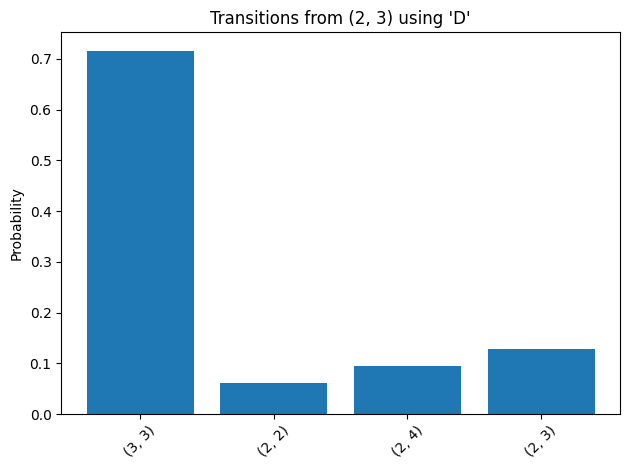

In [ ]:
# Code for Task 1
# This shows the transition probilities P(s'|s,a) when the state is s=(2,2) and the action is 'U'

#########################################
#### This part you can play with ########
#########################################

state = (2, 3) # Test changing the state
action = 'D'   # Test changing the actions, possible actions are 'U', 'D', 'L', 'R'

#########################################
#########################################
#########################################

probs = env.transition_probs(state, action)
for s2, p in probs:
    print(f"{state} --'{action}'--> {s2} with prob {p:.2f}")

# Make bar plot:
labels = [str(s) for s, _ in probs]
values = [p for _, p in probs]
plt.bar(labels, values)
plt.title(f"Transitions from {state} using '{action}'")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Exploring state and actions:

<span style="color:red">

- ✅ **Intended move**: Probability the action works as planned.  
- ❌ **Slips sideways**: Probability the agent moves in an unintended direction.  
- ❌ **Stay in place**: Probability the agent doesn’t move (represents congestion or obstacles).

So for state (3,4) using "L", 63% to go as intended, 9% chance slips up, 8% chance slips down, 20% chance get stuck

It means:

- You start at state (3,4) (row 3, column 4)
- You choose action 'L' (move LEFT)
- There is a 63% chance you actually move to (3,3) — the intended left move

Comparing different: 

(3, 4) --'L'--> (3, 3) with prob 0.63  
(3, 4) --'L'--> (2, 4) with prob 0.09  
(3, 4) --'L'--> (4, 4) with prob 0.08  
(3, 4) --'L'--> (3, 4) with prob 0.20  

(4, 2) --'U'--> (3, 2) with prob 0.79  
(4, 2) --'U'--> (4, 1) with prob 0.09  
(4, 2) --'U'--> (4, 3) with prob 0.06  
(4, 2) --'U'--> (4, 2) with prob 0.06  

(2, 3) --'D'--> (3, 3) with prob 0.72  
(2, 3) --'D'--> (2, 2) with prob 0.06  
(2, 3) --'D'--> (2, 4) with prob 0.09  
(2, 3) --'D'--> (2, 3) with prob 0.13

</span>


**Task 2:** Evaluate Fixed Policies via Linear System


We provide code that computes the value function for two fixed policies:

**Policy 1:** Always try to send the packet to the 'R' (right).

**Policy 2:** Always try to send the packet to the 'D' (down).


Run both examples and inspect the provided heatmaps. Be prepared to answer the Task 2 questions in the handout

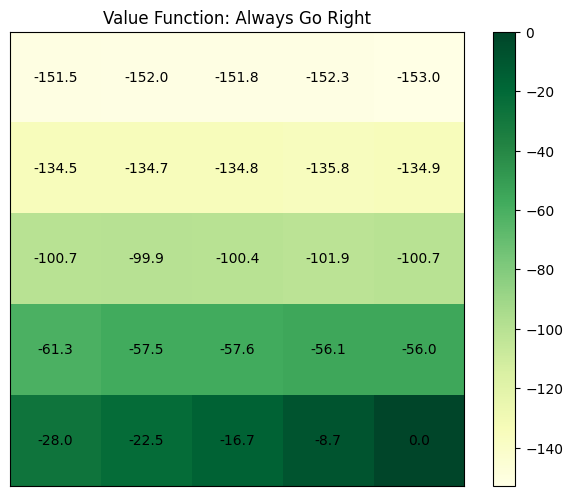

In [28]:
### Task 2
### Here we plot the value function for the policy that always attempts to go right
#


# Create the policy:
pi_right = build_policy(env.states, 'R')

# Perform policy evalution by solivng a linear system:
V_right = env.evaluate_policy(pi_right)

# Plot value function heatmap
plot_value_function(V_right, "Value Function: Always Go Right")


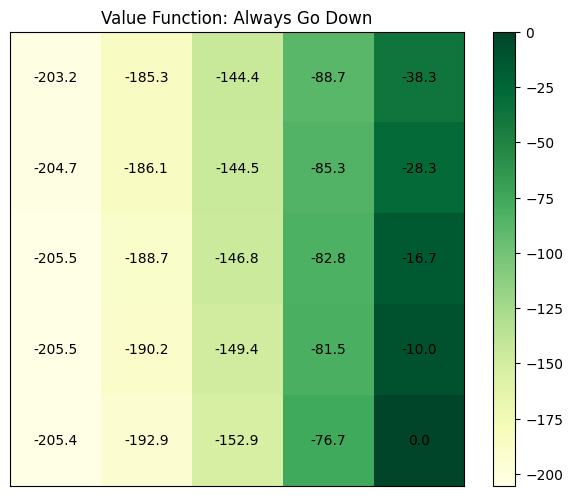

In [6]:
### Task 2 (Part 2)
### Here we plot the value function for the policy that always attempts to go down
#

# Create the policy:
pi_down = build_policy(env.states, 'D')

# Perform policy evalution by solivng a linear system:
V_up = env.evaluate_policy(pi_down)

# Plot value function heatmap:
plot_value_function(V_up, "Value Function: Always Go Down")

### Heatmaps comparison:

<span style="color:red">

- **Always Go Right ('R')**  
  - Values improve smoothly toward the bottom-right goal (4,4).  
  - Top-left corner is worst (~–151), but the policy generally moves toward the goal.  
  - Reasonable expected number of steps; sensible policy.  

- **Always Go Down ('D')**  
  - Values are worse far from the goal (top-left ~–203).  
  - Policy moves down first, then right, so it spends more time away from the goal initially.  
  - Inefficient; takes more steps to reach the goal than Always-Right.  

**Takeaway:**
- Choosing actions that **prioritize reaching the goal’s right column first** (Always-Right) leads to **fewer steps and lower total cost**.  
- Policies that **go down first** (Always-Down) delay progress horizontally, resulting in **more steps and higher negative values**.

</span>


**Task 3:** Simulating Policies & Estimating Value

**What to do**
1. **Play with simulations:** Use the code given in Part 1 and Part 2 below. It uses simulates trajectories for different policies (e.g., always `R`, always `D`, or a mix like 70% `R` / 30% `D`). You can visualize a few trajectories (this is illustrated in Part 3).

2. **Main experiment** Use the code provided in Part 4. Run many episodes from start state `(0,0)` for **Policy 1** (always `R`) and **Policy 2** (always `D`). Record:
   - average return (mean over episodes),
   - mean number of steps,
   - success rate (fraction reaching the goal).
3. **Compare to Task 2:** Compare each policy’s **empirical average return** to the **value** you computed via the linear-system evaluation in Task 2 for the same start state.
4. **Be ready to explain:**
   - What is a trajectory? Why is it (typically) different at each episode? What controls
the randomness?
   - How the empirical average return **estimates** \(V^\pi(s_0)\): this is **Monte Carlo policy evaluation** (no model used—only observed states and rewards). With enough episodes, the average return converges to the true value (Lecture 5).



In [7]:
# Task 3 (Part 1)
#
# This simulates one instance of the MDP where we follow Policy 1 (always try
# to send the package to right) and we start in state (0,0)
#
#

# This is the random seed, change it to try different realizations
simulation_seed = 100

# Reproducible RNG
rng = np.random.default_rng(simulation_seed)

# Create the policy, always try right
pi_right = {s: 'R' for s in env.states}

# Simulate:
out1 = env.simulate(pi_right, start=(0, 0), max_steps=5000, rng=rng)

# Print the results:
print("Deterministic (Right):", out1['reached_goal'], out1['steps'], out1['total_reward'])
print("Trajectory (first 100 states):", out1['states'][:100])



Deterministic (Right): True 135 -134.0
Trajectory (first 100 states): [(0, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 3), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (1, 4), (1, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4)]


### Explanation:
<span style="color:red">

- Policy: Always go Right ('R') from every state (deterministic)
- Environment: Stochastic — slips, sideways moves, or staying in place can occur
- Trajectory: Sequence of states actually visited in one run from start to goal. Each run can differ due to randomness
- Steps: 135 steps here (reward -134) → much longer than ideal 8 steps, because Always-Right often gets stuck or slips

Takeaway: Even a simple policy can perform poorly in a stochastic environment; the trajectory shows how randomness affects the path.

</span>

In [31]:
# Task 3 (Part 2)
#
# This simulates one instance of the MDP where we follow a random policy that
# goes Right 'R' with probability 0.7 and Down'D' with probablity 0.3 and start
# in state (0,0)
#

# This is the random seed, change it to try different realizations
simulation_seed = 120
rng = np.random.default_rng(simulation_seed)

# Stochastic policy: 70% Right, 30% Down
pi_mix = {s: {'R': 0.7, 'D': 0.3} for s in env.states}

# Simulate a stochastic policy from (2,2)
out2 = env.simulate(pi_mix, start=(2, 2), max_steps=500, rng=rng)
print("Stochastic (0.7R/0.3D):", out2['reached_goal'], out2['steps'], out2['total_reward'])
print("Trajectory (first 100 states):", out2['states'][:10])


Stochastic (0.7R/0.3D): True 15 -14.0
Trajectory (first 100 states): [(2, 2), (3, 2), (3, 3), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4), (3, 4)]


In [34]:
# Stochastic policy: 80% Right, 20% Down
pi_8020 = {s: {'R': 0.8, 'D': 0.2} for s in env.states}

# Simulate a stochastic policy from (2,2)
simulation_seed = 123
rng = np.random.default_rng(simulation_seed)
out_8020 = env.simulate(pi_8020, start=(2,2), max_steps=500, rng=rng)

print("Stochastic (0.8R/0.2D):", out_8020['reached_goal'], out_8020['steps'], out_8020['total_reward'])
print("Trajectory (first 10 states):", out_8020['states'][:10])


Stochastic (0.8R/0.2D): True 7 -6.0
Trajectory (first 10 states): [(2, 2), (2, 3), (2, 4), (2, 4), (3, 4), (3, 4), (3, 4), (4, 4)]


### Explanation:
<span style="color:red">

- We simulate how the agent moves starting at (2,2) using randomized policies.
- A policy says how likely the agent is to take each action, like 70% Right and 30% Down.
- The trajectory is the path the agent actually takes. It can be different each time because of randomness.
- Steps and total reward show how quickly and efficiently the agent reaches the goal.

Example comparision:
- **0.7R / 0.3D**  
  - Reached goal ✅ in 15 steps  
  - Total reward: -14  
  - Trajectory (first 10 states): [(2,2), (3,2), (3,3), (3,4), ...]  

- **0.8R / 0.2D**  
  - Reached goal ✅ in 7 steps  
  - Total reward: -6  
  - Trajectory (first 8 states): [(2,2), (2,3), (2,4), (3,4), ...]  

</span>

In [35]:
# Task 3 (Part 3)
#
# This is optional.
#
# If you run this you can visuallize one simulation. Play around with changing
# the policy, changing the random seed, the start state.


# Take any policy
pi_right = {s: 'R' for s in env.states}
#pi_mix = {s: {'R': 0.7, 'D': 0.3} for s in env.states}


# This is the random seed, change it to try different realizations
simulation_seed = 233
rng = np.random.default_rng(simulation_seed)

# Run one simulation from (1,0)
sim_out = env.simulate(pi_right, start=(0,0), max_steps=1000, rng=rng)

# Animate (in Jupyter, this will display below)
anim = animate_simulation(env, sim_out, interval=200, trail=True)
from IPython.display import HTML
HTML(anim.to_jshtml())  # or display(anim)

In [14]:
# Task 3 (Part 4): Monte Carlo estimation of value under a fixed policy
#
# In this section we estimate the value of a policy by running many simulated
# episodes and averaging the observed returns — i.e., a Monte Carlo (MC)
# estimator. You can change:
#   - the policy (e.g., always 'R' vs always 'D', or a stochastic policy),
#   - the start state,
#   - the number of simulations (n_sims).
#
# What to do:
# 1) Run multiple simulations following a fixed policy from s0 = (0,0).
# 2) Compute the empirical average return across runs.
# 3) Compare this average return for Policy 1 and Policy 2 to the value you
#    computed earlier via the linear-system method (policy evaluation).
#
# Notes:
# • This uses no model knowledge beyond observing states and rewards — it is an
#   example of a Reinforcement Learning approach (Monte Carlo policy evaluation),
#   which we will discuss in Lecture 5.
# • With enough runs, the MC average should approach the true value V^π(s0).

pi_right = {s: 'R' for s in env.states}

results = run_many_simulations(env, pi_right, n_sims=100, start=(0,0), max_steps=100000)
print("Summary:", results['summary'])

# Simulate Policy 2: always Down
pi_down = {s: 'D' for s in env.states}

results_down = run_many_simulations(env, pi_down, n_sims=100, start=(0,0), max_steps=100000)
print("Summary for Down policy:", results_down['summary'])

Summary: {'mean_total_reward': -226.37, 'mean_steps': 227.37, 'success_rate': 1.0}
Summary for Down policy: {'mean_total_reward': -176.66, 'mean_steps': 177.66, 'success_rate': 1.0}


### Explanation:
<span style="color:red">

- **Goal:** Estimate policy value by simulating many episodes from `(0,0)` and averaging total rewards.  
- **Policies:** Always Right (`R`) vs Always Down (`D`)  
- **Output:** Mean reward, mean steps, success rate  

**Results:**  
- **Always Right:** -226.37 reward, 227 steps, 100% success  
- **Always Down:** -176.66 reward, 178 steps, 100% success  

**Interpretation:**  
- Down policy is more efficient here (fewer steps, less negative reward)  
- MC average approximates the true expected value \(V^\pi(0,0)\)  
- Randomness (slips/stays) causes different trajectories each run

</span>


**Task 4:** Value Iteration (Optimal Value & Policy)

**Your tasks (no solutions here):**
- **Explain “optimal”:** Briefly state, in your own words, what it means for a policy/value to be *optimal* in this setting.
- **Explain the idea of value iteration:** Summarize how repeated Bellman *optimality* backups produce the fixed point used here; mention why we keep \(V(\text{goal})=0\) and when we stop iterating.
- **From \(V^*\) to \(\pi^*\):** Describe how one-step lookahead with \(V^*\) yields an optimal policy (argmax over actions).
- **Inspect results:** Look at the optimal value heatmap and (optionally) visualize arrows/actions for \(\pi^*\). Relate patterns to the goal location and slip dynamics.

**Optional prompts:**
- Compare \(V^*(s_0)\) with values from Task 2’s fixed policies at the same start state \(s_0\).
- If you simulate trajectories under \(\pi^*\), what do you observe about returns and paths?



VI iterations: 47 max residual: 7.480984720587003e-09


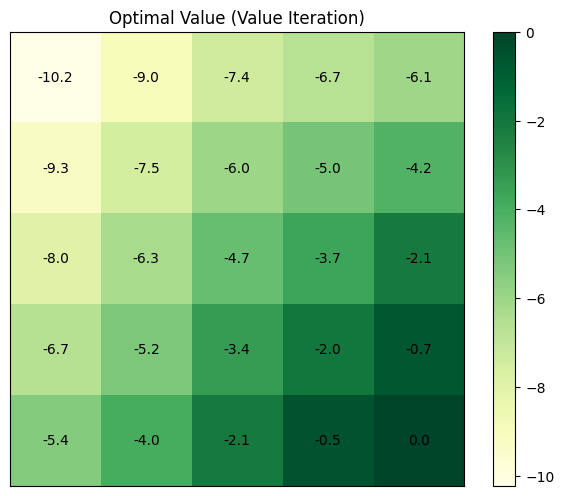

In [15]:
V_opt, pi_opt, info = env.value_iteration(tol=1e-8, max_iters=10000)
print("VI iterations:", info['iterations'], "max residual:", info['max_residual'])
plot_value_function(V_opt, "Optimal Value (Value Iteration)")

### Explanation: 
<span style="color:red">

**What This Task Does**
- Finds the best way to reach the goal from every square on the grid
- Repeatedly updates the expected “cost” (or steps) from each square until the numbers settle
- From these values, picks the best move at each square to create the optimal policy

**What “Optimal” Means**
- A policy is optimal if it gets to the goal in the fewest steps or lowest cost from anywhere.  
- The value for each square tells you roughly how many steps it takes if you follow the best path.  
- **Analogy:** A robot always chooses the fastest route to the treasure, avoiding wasted moves

**What is Value Iteration**
- Looks at all possible moves from each square to see which leads to the best outcome.  
- Keeps updating the values until they stop changing, showing the shortest expected path from every square
- **Analogy:** The robot mentally tests every route, keeps track of how long each takes, and updates its “map” until it knows the fastest path from everywhere

**Heatmap Interpretation**
- Shows the *minimum expected steps/cost to reach the goal from each square
- **Top-left corner:** Worst starting point (~10 steps to goal)  
- **Goal square:** 0 steps
- **Gradient:** Smooth improvement from start to goal
- **Colors:** Light = far from goal, dark = close

**Takeaways**
- **Optimal policy is much better than simple policies:**  
  - Always Right: 151 steps  
  - Always Down: 203 steps  
  - Optimal: 10 steps ✅  
- The optimal policy adapts at each square based on slips, boundaries, and goal location
- Simple policies are rigid; the optimal policy chooses dynamically

</span>
